In [1]:
from pathlib import Path
from math import ceil

import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.crimp import crimp
from src.baselines import (
    rank_degree,
    rank_betweenness,
    rank_pagerank,
    rank_cycle_ratio_base,
)
from src.datasets import DATASETS, load_edgelist_txt

In [2]:
# Load datasets and compute basic network statistics
graphs = {}
rows = []

for name, rel_path in DATASETS.items():
    path = Path(rel_path)
    G = load_edgelist_txt(path, directed=False)
    G = nx.Graph(G)  # ensure undirected
    G.remove_edges_from(nx.selfloop_edges(G))

    graphs[name] = G

    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_degree = (2 * m / n) if n > 0 else 0.0

    rows.append({
        "dataset": name,
        "nodes": n,
        "edges": m,
        "avg_degree": avg_degree,
        "is_connected": nx.is_connected(G) if n > 0 else False,
        "num_components": nx.number_connected_components(G) if n > 0 else 0,
    })

summary_df = pd.DataFrame(rows).sort_values("nodes", ascending=False).reset_index(drop=True)
summary_df

,dataset,nodes,edges,avg_degree,is_connected,num_components
0,Yeast,2375,11693,9.846737,True,1
1,Email,1133,5451,9.622242,True,1
2,NS_GC,379,914,4.823219,True,1
3,USAir,332,2126,12.807229,True,1
4,Celegans,297,2148,14.464646,True,1
5,Jazz,198,2742,27.696970,True,1


In [3]:
def rank_crimp(G):
    return crimp(G).r_imp

rankers = {
    "CRimp": rank_crimp,
    "CycleRatioBase": rank_cycle_ratio_base,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

def giant_component_fraction(G):
    n = G.number_of_nodes()
    if n == 0:
        return 0.0
    gcc = max((len(c) for c in nx.connected_components(G)), default=0)
    return gcc / n

def targeted_removal_curve(G, ordering):
    H = G.copy()
    n0 = H.number_of_nodes()

    removed = 0
    rows = [{"removed_frac": 0.0, "gcc_frac": giant_component_fraction(H)}]

    for node in ordering:
        if H.has_node(node):
            H.remove_node(node)
            removed += 1
            rows.append({
                "removed_frac": removed / n0,
                "gcc_frac": giant_component_fraction(H)
            })

    return pd.DataFrame(rows)

def auc(x, y):
    return float(np.trapezoid(y, x))

def gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)):
    out = {}
    for p in points:
        out[f"gcc@{p}"] = float(np.interp(p, x, y))
    return out

def p_star(x, y, thresh=0.1):
    y = np.array(y)
    x = np.array(x)
    idx = np.where(y <= thresh)[0]
    return float(x[idx[0]]) if len(idx) else 1.0

In [4]:
OUT_DIR = Path("../results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

all_metrics = []

for ds_name, G in graphs.items():
    curves = []
    for method, fn in rankers.items():
        scores = fn(G)
        ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
        df_curve = targeted_removal_curve(G, ordering)
        df_curve["dataset"] = ds_name
        df_curve["method"] = method
        curves.append(df_curve)

    perc_df = pd.concat(curves, ignore_index=True)

    # metrics table for this dataset
    for method in perc_df["method"].unique():
        tmp = perc_df[(perc_df["dataset"] == ds_name) & (perc_df["method"] == method)].sort_values("removed_frac")
        x = tmp["removed_frac"].values
        y = tmp["gcc_frac"].values

        row = {"dataset": ds_name, "method": method}
        row["auc"] = auc(x, y)
        row["p_star_gcc_lt_0.1"] = p_star(x, y, thresh=0.1)
        row.update(gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)))
        all_metrics.append(row)

metrics_df = pd.DataFrame(all_metrics).sort_values(["dataset", "auc"]).reset_index(drop=True)
metrics_df.to_csv(OUT_DIR / "percolation_metrics_real_datasets.csv", index=False)

metrics_df

,dataset,method,auc,p_star_gcc_lt_0.1,gcc@0.1,gcc@0.2,gcc@0.3,gcc@0.5
0,Celegans,PageRank,0.451588,0.626263,0.928919,0.907407,0.870130,0.350172
1,Celegans,CRimp,0.453162,0.521886,0.932660,0.903198,0.855700,0.407378
2,Celegans,Degree,0.459139,0.636364,0.928919,0.915825,0.884560,0.383843
3,Celegans,CycleRatioBase,0.492366,0.720539,0.936401,0.897302,0.874940,0.346771
4,Celegans,Betweenness,0.505905,0.794613,0.936401,0.920033,0.884560,0.424247
5,Email,PageRank,0.292161,0.382171,0.914386,0.804722,0.614550,0.010591
6,Email,CRimp,0.294622,0.412180,0.895753,0.783098,0.586433,0.014122
7,Email,CycleRatioBase,0.301151,0.370697,0.928116,0.815755,0.618081,0.014122
8,Email,Degree,0.310754,0.399823,0.928410,0.831641,0.630184,0.015887
9,Email,Betweenness,0.324180,0.432480,0.907816,0.799206,0.621611,0.033539


In [5]:
best_df = (
    metrics_df.sort_values(["dataset", "auc"])
    .groupby("dataset", as_index=False)
    .head(1)
    .reset_index(drop=True)
)
best_df

,dataset,method,auc,p_star_gcc_lt_0.1,gcc@0.1,gcc@0.2,gcc@0.3,gcc@0.5
0,Celegans,PageRank,0.451588,0.626263,0.928919,0.907407,0.870130,0.350172
1,Email,PageRank,0.292161,0.382171,0.914386,0.804722,0.614550,0.010591
2,Jazz,Betweenness,0.600194,0.782828,0.971941,0.962121,0.935064,0.858586
3,NS_GC,CycleRatioBase,0.073314,0.084433,0.076224,0.046174,0.022616,0.026385
4,USAir,PageRank,0.137729,0.180723,0.588997,0.089599,0.064544,0.024096
5,Yeast,PageRank,0.155479,0.233263,0.714620,0.345789,0.031278,0.005895


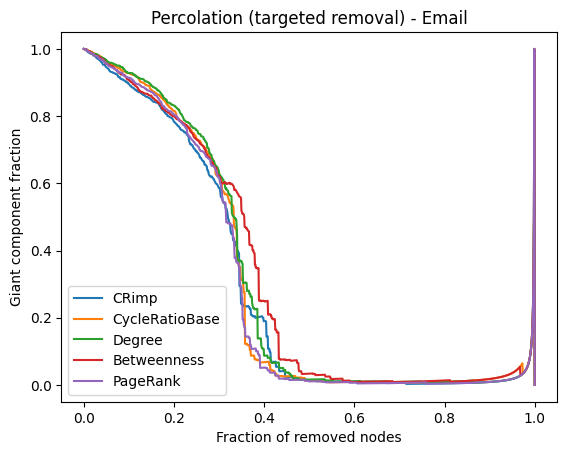

In [6]:
ds_name = "Email"
G = graphs[ds_name]

curves = []
for method, fn in rankers.items():
    scores = fn(G)
    ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    df_curve = targeted_removal_curve(G, ordering)
    df_curve["method"] = method
    curves.append(df_curve)

perc_one = pd.concat(curves, ignore_index=True)

for method in perc_one["method"].unique():
    tmp = perc_one[perc_one["method"] == method]
    plt.plot(tmp["removed_frac"], tmp["gcc_frac"], label=method)

plt.title(f"Percolation (targeted removal) - {ds_name}")
plt.xlabel("Fraction of removed nodes")
plt.ylabel("Giant component fraction")
plt.legend()
plt.show()

In [7]:
GLOBAL_SEED = 123

def rank_crimp(G):
    return crimp(G).r_imp

rankers = {
    "CRimp": rank_crimp,
    "CycleRatioBase": rank_cycle_ratio_base,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

def topk_from_scores(score_dict, k):
    return [n for n, _ in sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]]

In [8]:
def simulate_sir_once(G, seeds, beta=0.03, gamma=0.1, max_steps=200, rng=None):
    """
    Discrete-time SIR simulation (synchronous updates).
    States: 0=S, 1=I, 2=R

    Returns:
        timeline: list of (S_count, I_count, R_count)
        final_R: final recovered count
        peak_I: peak infected count
    """
    if rng is None:
        rng = random.Random()

    state = {u: 0 for u in G.nodes()}
    for s in seeds:
        state[s] = 1

    timeline = []

    for _ in range(max_steps):
        S = sum(1 for u in state if state[u] == 0)
        I = sum(1 for u in state if state[u] == 1)
        R = sum(1 for u in state if state[u] == 2)
        timeline.append((S, I, R))

        if I == 0:
            break

        to_infect = set()
        to_recover = set()

        # Decide transitions based on current state (synchronous update)
        for u in G.nodes():
            if state[u] == 1:
                # Recovery
                if rng.random() < gamma:
                    to_recover.add(u)
                # Infection attempts to neighbors
                for v in G.neighbors(u):
                    if state[v] == 0:
                        if rng.random() < beta:
                            to_infect.add(v)

        for v in to_infect:
            state[v] = 1
        for u in to_recover:
            state[u] = 2

    final_R = timeline[-1][2]
    peak_I = max(x[1] for x in timeline)
    return timeline, final_R, peak_I


def simulate_sir(G, seeds, beta=0.03, gamma=0.1, max_steps=200, runs=200, seed=42):
    """
    Monte Carlo wrapper.
    Returns mean final recovered fraction and mean peak infected fraction.
    """
    rng = random.Random(seed)
    n = G.number_of_nodes()

    final_R_list = []
    peak_I_list = []

    for _ in range(runs):
        # Use independent RNG stream
        sub_rng = random.Random(rng.getrandbits(32))
        _, final_R, peak_I = simulate_sir_once(G, seeds, beta, gamma, max_steps, rng=sub_rng)
        final_R_list.append(final_R / n)
        peak_I_list.append(peak_I / n)

    return float(np.mean(final_R_list)), float(np.mean(peak_I_list))

In [9]:
G_test = nx.karate_club_graph()
scores = rank_degree(G_test)
seeds = topk_from_scores(scores, 3)

a1 = simulate_sir(G_test, seeds, beta=0.03, gamma=0.1, runs=50, seed=GLOBAL_SEED)
a2 = simulate_sir(G_test, seeds, beta=0.03, gamma=0.1, runs=50, seed=GLOBAL_SEED)

a1, a2

((0.49529411764705883, 0.2529411764705882),
 (0.49529411764705883, 0.2529411764705882))

In [15]:
OUT_DIR = Path("../results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

beta = 0.03
gamma = 0.10
runs = 200
max_steps = 200

# k as percentage of nodes
k_fracs = [0.01, 0.03, 0.05]

rows = []
for ds_name, G in graphs.items():
    n = G.number_of_nodes()
    ks = [max(1, ceil(n * f)) for f in k_fracs]

    for k in ks:
        for method, fn in rankers.items():
            scores = fn(G)
            seeds = topk_from_scores(scores, k)

            mean_final, mean_peak = simulate_sir(
                G,
                seeds,
                beta=beta,
                gamma=gamma,
                max_steps=max_steps,
                runs=runs,
                seed=GLOBAL_SEED + k,
            )

            rows.append({
                "dataset": ds_name,
                "method": method,
                "k": k,
                "k_frac": k / n,
                "beta": beta,
                "gamma": gamma,
                "runs": runs,
                "max_steps": max_steps,
                "mean_final_recovered": mean_final,
                "mean_peak_infected": mean_peak,
            })

sir_real_df = (
    pd.DataFrame(rows)
    .sort_values(["dataset", "k", "mean_final_recovered"], ascending=[True, True, False])
    .reset_index(drop=True)
)

sir_real_df.to_csv(OUT_DIR / "sir_metrics_real_datasets.csv", index=False)

sir_real_df.head(25)

,dataset,method,k,k_frac,beta,gamma,runs,max_steps,mean_final_recovered,mean_peak_infected
0,Celegans,CRimp,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
1,Celegans,CycleRatioBase,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
2,Celegans,Degree,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
3,Celegans,Betweenness,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
4,Celegans,PageRank,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
5,Celegans,CRimp,9,0.030303,0.03,0.1,200,200,0.877542,0.409949
6,Celegans,Betweenness,9,0.030303,0.03,0.1,200,200,0.874007,0.406077
7,Celegans,PageRank,9,0.030303,0.03,0.1,200,200,0.872795,0.408316
8,Celegans,Degree,9,0.030303,0.03,0.1,200,200,0.872593,0.407306
9,Celegans,CycleRatioBase,9,0.030303,0.03,0.1,200,200,0.868114,0.402323


In [16]:
best_sir_df = (
    sir_real_df.sort_values(["dataset", "k", "mean_final_recovered"], ascending=[True, True, False])
    .groupby(["dataset", "k"], as_index=False)
    .head(1)
    .reset_index(drop=True)
)

best_sir_df

,dataset,method,k,k_frac,beta,gamma,runs,max_steps,mean_final_recovered,mean_peak_infected
0,Celegans,CRimp,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
1,Celegans,CRimp,9,0.030303,0.03,0.1,200,200,0.877542,0.409949
2,Celegans,CycleRatioBase,15,0.050505,0.03,0.1,200,200,0.874545,0.408603
3,Email,CycleRatioBase,12,0.010591,0.03,0.1,200,200,0.685914,0.260838
4,Email,CRimp,34,0.030009,0.03,0.1,200,200,0.686655,0.271814
5,Email,CRimp,57,0.050309,0.03,0.1,200,200,0.687546,0.283054
6,Jazz,CRimp,2,0.010101,0.03,0.1,200,200,0.927652,0.546212
7,Jazz,PageRank,6,0.030303,0.03,0.1,200,200,0.927677,0.560934
8,Jazz,Betweenness,10,0.050505,0.03,0.1,200,200,0.933005,0.575783
9,NS_GC,CRimp,4,0.010554,0.03,0.1,200,200,0.162375,0.057243


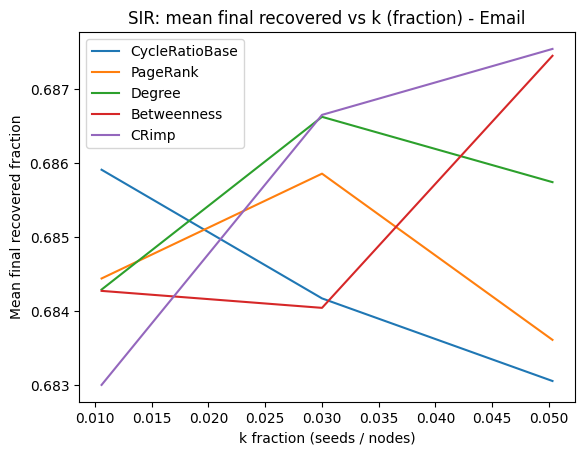

In [17]:
ds_name = "Email"
tmp = sir_real_df[sir_real_df["dataset"] == ds_name]

for method in tmp["method"].unique():
    m = tmp[tmp["method"] == method].sort_values("k_frac")
    plt.plot(m["k_frac"], m["mean_final_recovered"], label=method)

plt.title(f"SIR: mean final recovered vs k (fraction) - {ds_name}")
plt.xlabel("k fraction (seeds / nodes)")
plt.ylabel("Mean final recovered fraction")
plt.legend()
plt.show()

In [18]:
seed_rows = []
for ds_name, G in graphs.items():
    n = G.number_of_nodes()
    ks = [max(1, ceil(n * f)) for f in k_fracs]

    for k in ks:
        for method, fn in rankers.items():
            scores = fn(G)
            seeds = topk_from_scores(scores, k)
            seed_rows.append({
                "dataset": ds_name,
                "method": method,
                "k": k,
                "k_frac": k / n,
                "seeds": seeds,
            })

seed_df = pd.DataFrame(seed_rows)
seed_df.to_csv(OUT_DIR / "sir_seeds_real_datasets.csv", index=False)
seed_df.head()

,dataset,method,k,k_frac,seeds
0,Celegans,CRimp,3,0.010101,"[295, 71, 70]"
1,Celegans,CycleRatioBase,3,0.010101,"[295, 70, 71]"
2,Celegans,Degree,3,0.010101,"[295, 70, 71]"
3,Celegans,Betweenness,3,0.010101,"[295, 70, 71]"
4,Celegans,PageRank,3,0.010101,"[295, 70, 71]"


In [19]:
sir_real_df_rounded = sir_real_df.copy()
for c in ["k_frac", "mean_final_recovered", "mean_peak_infected"]:
    sir_real_df_rounded[c] = sir_real_df_rounded[c].astype(float).round(6)
sir_real_df_rounded.head()

,dataset,method,k,k_frac,beta,gamma,runs,max_steps,mean_final_recovered,mean_peak_infected
0,Celegans,CRimp,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
1,Celegans,CycleRatioBase,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
2,Celegans,Degree,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
3,Celegans,Betweenness,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
4,Celegans,PageRank,3,0.010101,0.03,0.1,200,200,0.873535,0.399057
